# Train MARBLE and Cebra

In this notebook we train the MARBLE and Cebra models to analyse the rat hippocampal data

In [3]:
! pip install cebra elephant

import numpy as np
import matplotlib.pyplot as plt
import pickle

from cebra import CEBRA

import MARBLE
from rat_utils import *

## Load the data

In [2]:
!mkdir data
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7609512 -O data/rat_data.pkl

with open('data/rat_data.pkl', 'rb') as handle:
    hippocampus_pos = pickle.load(handle)
    
rat = 'achilles'
hippocampus_pos = hippocampus_pos[rat]

mkdir: cannot create directory ‘data’: File exists
File ‘data/rat_data.pkl’ already there; not retrieving.


## Train the models

*[This can be skipped if you already saved the models].*

In [3]:
# defining train and test splits of the data

def split_data(data, test_ratio):

    split_idx = int(data['neural'].shape[0] * (1-test_ratio))
    neural_train = data['neural'][:split_idx]
    neural_test = data['neural'][split_idx:]
    label_train = data['continuous_index'][:split_idx]
    label_test = data['continuous_index'][split_idx:]
    
    return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()

neural_train, neural_test, label_train, label_test = split_data(hippocampus_pos, 0.2)

Text(0.5, 0, 'Time (s)')

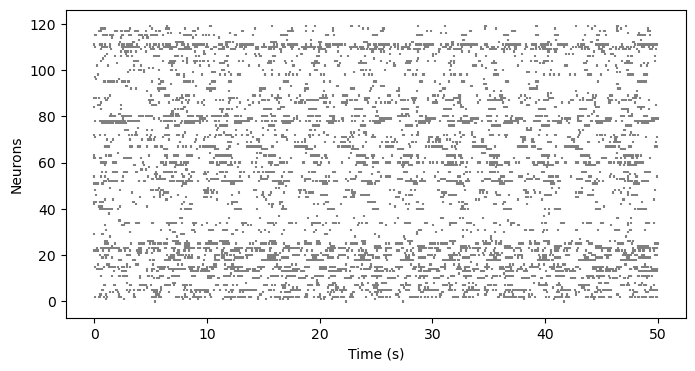

In [4]:
# 40 hz sampling rate (they binned into 25ms epochs

spikes = neural_train[:2000,:].T
spikes = [np.where(spikes[ch,:])[0]/40 for ch in range(120)] 
    
_, ax = plt.subplots(figsize=(8,4))
ax.eventplot(spikes,color='gray')
plt.ylabel('Neurons')
plt.xlabel('Time (s)')

### Train CEBRA-time and Cebra-behaviour on all animals

In [5]:
max_iterations = 10000
output_dimension = 32 #set to 3 for embeddings and 32 for decoding

for rat in list(hippocampus_pos.keys()):

    print('train Cebra time')
    cebra_time = CEBRA(model_architecture='offset10-model',
                       batch_size=512,
                       learning_rate=3e-4,
                       temperature=1.12,
                       output_dimension=output_dimension,
                       max_iterations=10000,
                       distance='cosine',
                       conditional='time', # 'time' means we are only using time information in the samples
                       device='cuda_if_available',
                       verbose=True,
                       time_offsets=10)
    
    cebra_time.fit(hippocampus_pos[rat]["neural"])
    cebra_time.save(f"data/cebra_time_{rat}.pt")

    print('train Cebra behaviour')
    cebra_behaviour = CEBRA(model_architecture='offset10-model',
                            batch_size=512,
                            learning_rate=3e-4,
                            temperature=1,
                            output_dimension=output_dimension, 
                            max_iterations=max_iterations,
                            distance='cosine',
                            conditional='time_delta', #'time_delta' means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training
                            device='cuda_if_available',
                            verbose=True,
                            time_offsets=10)
    
    cebra_behaviour.fit(hippocampus_pos[rat]["neural"], hippocampus_pos[rat]['continuous_index'].numpy())
    cebra_behaviour.save(f"data/cebra_behaviour_{rat}.pt")

### Train MARBLE with only neural data

In [ ]:
for rat in list(hippocampus_pos.keys()):
    # build model 
    data, labels, _ = convert_spikes_to_rates(hippocampus_pos[rat]["neural"], label_train, pca_n=10)
    pickle.dump([data, labels], open(f'data/{rat}_preprocessed_data.pkl','wb'))
    
    # build model
    params = {
        "epochs": 100,
        "order": 1,  # order of derivatives
        "hidden_channels": [64],  # number of internal dimensions in MLP
        "out_channels": output_dimension, 
        "inner_product_features": False,
        "emb_norm": True, # spherical output embedding
        "diffusion": False,
        "include_positions": True,
      }
    
    model = MARBLE.net(data, params=params) #define model
    model.fit(data, outdir=f"data/hippocampus_{rat}") # train model
    data = model.transform(data) #evaluate model

## Train MARBLE with different preprocessing hyperparameters

Vary PCA dimension

In [ ]:
params = {
        "epochs": 100,
        "order": 1,  # order of derivatives
        "hidden_channels": [64],  # number of internal dimensions in MLP
        "out_channels": 32, 
        "emb_norm": True, # spherical output embedding
        "diffusion": False,
        "include_positions": True,
      }

In [ ]:
rat = 'achilles'
kernel_width = 10

for pca_n in [3,5,10,20,30]:
    data_train, label_train_marble, pca = prepare_marble(neural_train.T, 
                                                         label_train, 
                                                         pca_n=pca_n, 
                                                         kernel_width=kernel_width)

    model = MARBLE.net(data_train, params=params)
    model.fit(data_train, outdir=f"data/hippocampus_{rat}_pca{pca_n}")

Vary Gaussian kernel width

In [ ]:
pca_n = 20
rat = 'achilles'

for kernel_width in [3,5,10,20,30,50,100]:
    data_train, label_train_marble, pca = convert_spikes_to_rates(neural_train.T, 
                                                                  label_train, 
                                                                  pca_n=pca_n, 
                                                                  kernel_width=kernel_width)
    
    model = MARBLE.net(data_train, params=params)
    model.fit(data_train, outdir=f"data/hippocampus_achilles_kw{k_width}")